# Chapter 6
## Detrending




### Figure 6.1

In [1]:
################################ Preliminaries #################################
# --- hoursekeeping ---
remove(list = ls())

# --- packages ---
library(tidyverse)
library(readxl)
library(lubridate)
library(naniar)
library(chron)
library(tidyquant)
library(ggthemes)
library(zoo)
library(broom)

# --- options ---
options(scipen=999)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'chron'


The following objects are masked from 'package:lubridate':

    days, hours, minutes, seconds, years


Loading required package: PerformanceAnalytics

Loading required package: xts

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



######################### Warning from 'xts' package ##########################
#                                     

In [2]:
################################ Reading in Data #################################
fred <- read_xls("fredgraph_ch6.xls", skip = 19)
glimpse(fred)

Rows: 306
Columns: 11
$ observation_date <dttm> 1947-01-01, 1947-04-01, 1947-07-01, 1947-10-01, 1948…
$ PCND             <dbl> 74.872, 76.897, 78.649, 79.965, 81.546, 83.169, 83.46…
$ PCESV            <dbl> 60.567, 61.783, 63.124, 64.219, 65.279, 66.954, 68.33…
$ PCDG             <dbl> 20.722, 21.351, 21.770, 23.488, 23.547, 24.019, 25.27…
$ GPDI             <dbl> 35.854, 34.505, 34.911, 43.250, 47.202, 50.336, 52.51…
$ DNDGRG3Q086SBEA  <dbl> 14.518, 14.659, 14.924, 15.375, 15.627, 15.784, 15.93…
$ DSERRG3Q086SBEA  <dbl> 7.842, 7.885, 8.074, 8.257, 8.305, 8.387, 8.513, 8.54…
$ GPDICTPI         <dbl> 16.536, 17.169, 17.740, 17.954, 18.185, 18.575, 19.08…
$ DDURRG3Q086SBEA  <dbl> 46.500, 46.928, 47.190, 47.805, 48.170, 48.803, 50.50…
$ HOANBS           <dbl> 45.842, 45.854, 45.980, 46.425, 46.720, 46.700, 47.02…
$ CNP16OV          <dbl> NA, NA, NA, NA, 102690.7, 102915.3, 103249.0, 103417.…


The dataset is downloaded from FRED and contains the following quarterly series: a date column, four NIPA series in billions of current dollars (PCND, PCESV and PCDG are personal consumption of nondurable goods, of services and of durable goods, respectively, while GPDI is gross private domestic investment), the corresponding price indexes with base year 2012 (DNDGRG3Q086SBEA, DSERRG3Q086SBEA, DDURRG3Q086SBEA, GPDICTPI), hours worked in the nonfarm business sector (HOANBS) and population (CNP160V). 

Next, we make the following transformations:
- population is scaled by its 2012 value;
- consumption is calculated as the sum of consumption of nondurable goods and services;
- nominal NIPA series are divided by the corresponding price indexes to obtain consumption and investment in real terms;
- real output is computed as the sum of the just-derived real consumption and investment;
- per capita values of consumption, investment, output and hours are derived;
- finally, we take their logs. These real, per-capita, logged series are the ones shown in Figure 6.1, along with their trends;
- we get rid of NAs (we discard some 1947 values and 2023 observations).

In [3]:
################################ Data Wrangling and Manipulation #################################
# --- find 2012 average for population ---
base_year <- 2012
base_year_average <- fred %>%
  filter(year(observation_date) == base_year) %>%
  summarise(base_year_average = mean(CNP16OV)) %>%
  pull(base_year_average)

# --- perform the transformations ---
fred <- fred %>% na.omit() %>%
  mutate(POPULATION = CNP16OV/base_year_average,
         NONDURABLES = PCND/DNDGRG3Q086SBEA,
         SERVICES = PCESV/DSERRG3Q086SBEA,
         INVESTMENT = (GPDI/GPDICTPI)*100,
         DURABLES = PCDG/DDURRG3Q086SBEA,
         NCONSUMPTION = (PCND + PCESV), 
         CONSUMPTION = (NONDURABLES + SERVICES)*100, 
         OUTPUT = (CONSUMPTION+INVESTMENT),
         HOURS = HOANBS/3.5,
         across(c(CONSUMPTION,INVESTMENT,DURABLES,OUTPUT,HOURS),
                ~ ./POPULATION,.names = "{col}_pc"),
         across(c(CONSUMPTION_pc,INVESTMENT_pc,OUTPUT_pc,HOURS_pc),
                ~ log(.),.names = "{col}_log") )

glimpse(fred)

Rows: 301
Columns: 29
$ observation_date   <dttm> 1948-01-01, 1948-04-01, 1948-07-01, 1948-10-01, 19…
$ PCND               <dbl> 81.546, 83.169, 83.465, 83.686, 82.731, 81.894, 80.…
$ PCESV              <dbl> 65.279, 66.954, 68.330, 69.271, 69.664, 70.164, 70.…
$ PCDG               <dbl> 23.547, 24.019, 25.277, 24.971, 24.436, 26.389, 27.…
$ GPDI               <dbl> 47.202, 50.336, 52.516, 51.334, 43.140, 36.241, 39.…
$ DNDGRG3Q086SBEA    <dbl> 15.627, 15.784, 15.937, 15.772, 15.532, 15.332, 15.…
$ DSERRG3Q086SBEA    <dbl> 8.305, 8.387, 8.513, 8.544, 8.538, 8.556, 8.583, 8.…
$ GPDICTPI           <dbl> 18.185, 18.575, 19.086, 19.195, 19.138, 19.104, 18.…
$ DDURRG3Q086SBEA    <dbl> 48.170, 48.803, 50.501, 50.592, 50.422, 50.092, 49.…
$ HOANBS             <dbl> 46.720, 46.700, 47.029, 46.597, 45.813, 45.059, 44.…
$ CNP16OV            <dbl> 102690.7, 102915.3, 103249.0, 103417.7, 103584.3, 1…
$ POPULATION         <dbl> 0.4221014, 0.4230249, 0.4243964, 0.4250897, 0.42577…
$ NONDURABLES     

We save the variables and the sample shown in Figure 6.1.

In [4]:
# --- specifics for Figure 6.1 ---
fig61_vars   <- c("OUTPUT_pc_log","CONSUMPTION_pc_log","INVESTMENT_pc_log","HOURS_pc_log")
fig61_sample <- interval(ymd("1948-01-01"),ymd("2010-01-01"))

Let's check that we got the real, per-capita, log series right.

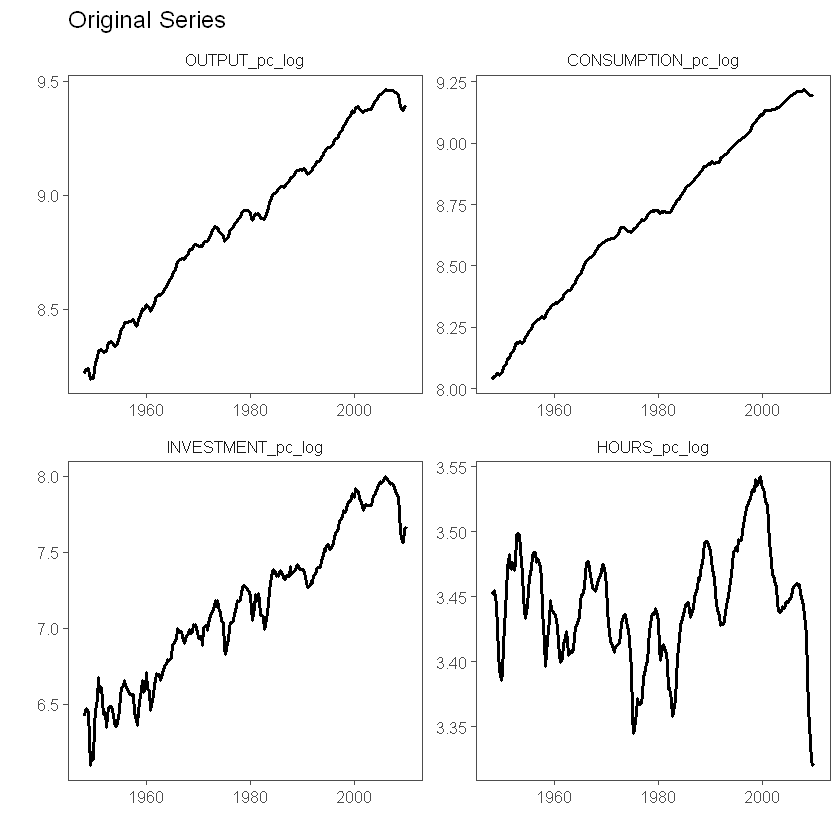

In [5]:
# --- first draft for Figure 6.1 ---
fred %>% pivot_longer(!observation_date) %>%
    filter(name %in% fig61_vars, observation_date %within% fig61_sample) %>%
    ggplot(aes(x = observation_date, y = value)) +
    geom_line(linewidth=1) +
    facet_wrap(~ factor(name, levels = fig61_vars), scales = "free") +
    labs(title = "Original Series",
       y = "",x="") +
    theme_few()

Even though we downloaded revised and updated data, not vintage data, it is hard to see any differences to Figure 6.1.

Now, we perform our first **detrending** and save the resulting trend and residual.

In [6]:
# --- loop over the three variables, detrend them for the period 1948Q1:2010Q1 and save the trend and residual component to fred ---
for (var in fig61_vars) {
  model <- lm(paste0(var, " ~ observation_date"), data = fred %>% filter(observation_date %within% fig61_sample))
  fitted_values <- fitted(model)
  residuals_values <- residuals(model)
  
  fred <- fred %>%
    mutate(!!paste0(var, "_fit10") := ifelse(observation_date %within% fig61_sample, fitted_values, NA_real_),
           !!paste0(var, "_res10") := ifelse(observation_date %within% fig61_sample, residuals_values, NA_real_)) %>%
    ungroup()
}

To display the trend on the same graph as the original series, we create a new data frame using pivot_longer() but instead of just having a date column, a variable name column and a value column, we add a fourth one such that we can assign the original values and the detrended one to the same name but differentiate between them based on the extra column.

In [7]:
# --- create extra dataset for figure 6.1 ---
fig61 <- fred %>% 
  filter(observation_date %within% fig61_sample) %>%
  select("observation_date",all_of(fig61_vars),paste(c("OUTPUT_pc_log","CONSUMPTION_pc_log","INVESTMENT_pc_log"),"_fit10",sep = "")) %>%
           pivot_longer(
  cols = -observation_date,
  names_to = c("name", "variable_type"),
  names_pattern = "(.*_pc_log)(.*)") 

# --- brief inspection ---
sample_n(fig61, 5)

observation_date,name,variable_type,value
<dttm>,<chr>,<chr>,<dbl>
1980-10-01,OUTPUT_pc_log,_fit10,8.931137
1958-07-01,CONSUMPTION_pc_log,_fit10,8.315146
2003-04-01,INVESTMENT_pc_log,,7.807592
2004-10-01,INVESTMENT_pc_log,_fit10,7.827739
1972-07-01,HOURS_pc_log,,3.414162


The replication of Figure 6.1 looks like this.

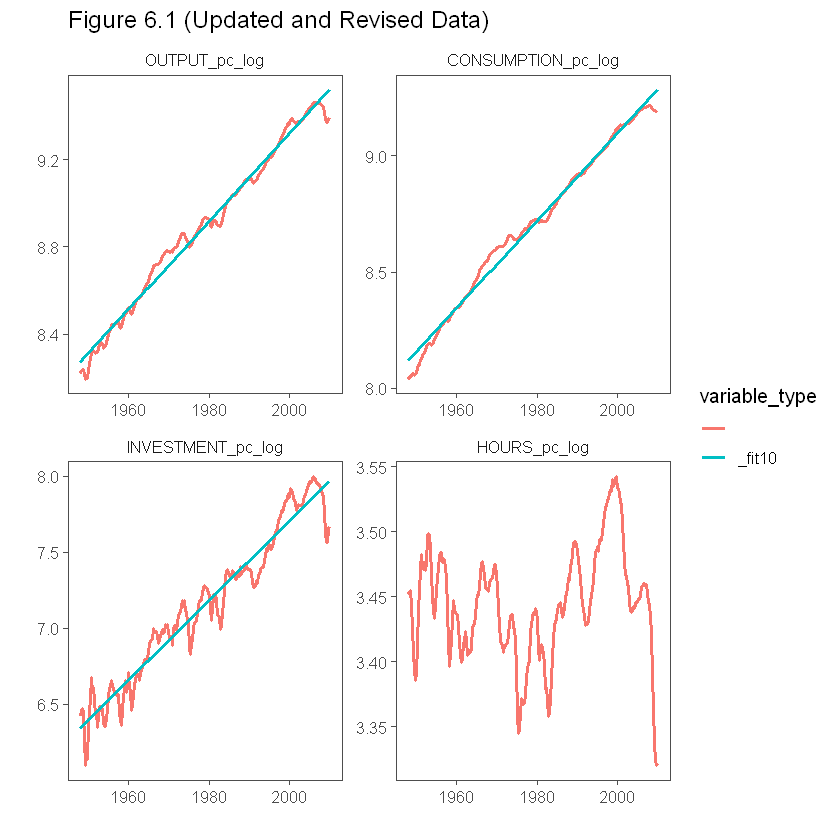

In [8]:
fig61 %>% ggplot(aes(x = observation_date, y = value, color = variable_type)) +
    geom_line(linewidth=1) +
    facet_wrap(~ factor(name, levels = fig61_vars), scales = "free") +
    labs(title = "Figure 6.1 (Updated and Revised Data)",y = "",x="") +
    theme_few()

Repeating this exercise for the entire sample:

In [9]:
# --- loop over the three variables, detrend them for the period 1948Q1:2023Q1 and save the trend and residual component to fred ---
for (var in fig61_vars) {
  model <- lm(paste0(var, " ~ observation_date"), data = fred)
  fitted_values <- fitted(model)
  residuals_values <- residuals(model)
  
  fred <- fred %>%
    mutate(!!paste0(var, "_fit") := fitted_values,
           !!paste0(var, "_res") := residuals_values) %>%
    ungroup()
}

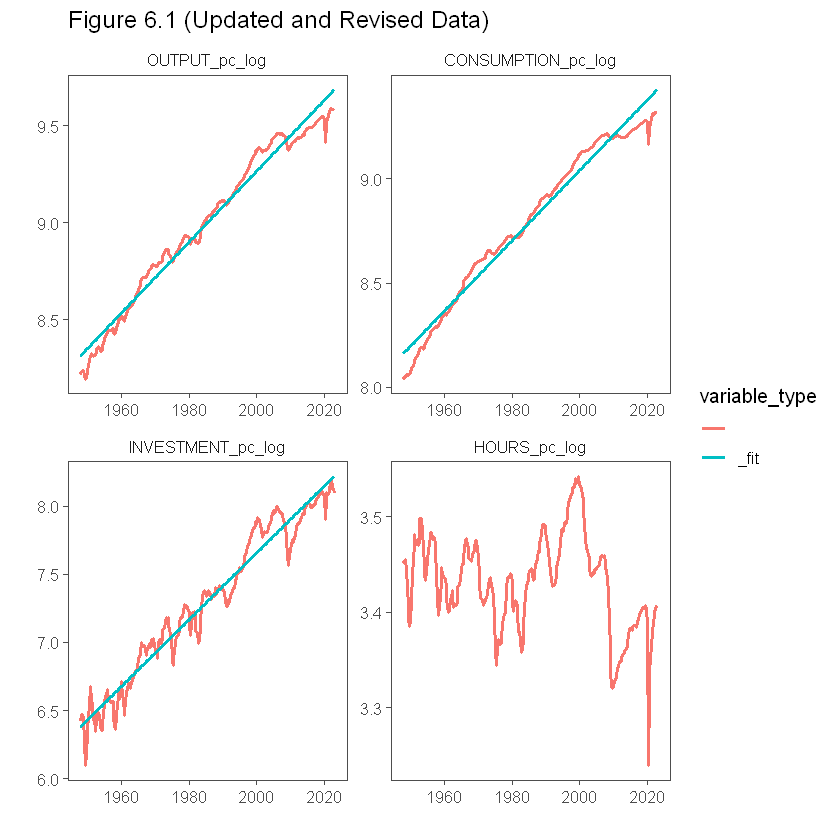

In [10]:
fred %>% 
    select("observation_date",all_of(fig61_vars),paste(c("OUTPUT_pc_log","CONSUMPTION_pc_log","INVESTMENT_pc_log"),"_fit",sep = "")) %>%
    pivot_longer(cols = -observation_date,
                 names_to = c("name", "variable_type"),
                 names_pattern = "(.*_pc_log)(.*)") %>%
    ggplot(aes(x = observation_date, y = value, color = variable_type)) +
    geom_line(linewidth=1) +
    facet_wrap(~ factor(name, levels = fig61_vars), scales = "free") +
    labs(title = "Figure 6.1 (Updated and Revised Data)",y = "",x="") +
    theme_few()